In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, Flatten, Activation
from tensorflow.keras.models import Sequential

class MultiplicationLayer(Layer):
    def __init__(self, num_filters_mult, L1, L2, **kwargs):
        super(MultiplicationLayer, self).__init__(**kwargs)
        self.num_filters_mult = num_filters_mult
        self.L1 = L1
        self.L2 = L2

    def build(self, input_shape):
        self.n = input_shape[2]  # Get the 'n' dimension from the input shape
        self.v = self.add_weight(name='v',
                                 shape=(self.n, 2,self.L1 * self.L2),  # Update the shape to (n, 2, L2)
                                 initializer='random_normal',
                                 trainable=True)
        super(MultiplicationLayer, self).build(input_shape)

    def call(self, inputs):
        # Initialize an empty list to store results for each filter
        results = []

        # Reshape v to match the desired shape
        v_reshaped = tf.reshape(self.v, (self.n, 2, self.L1 * self.L2))

        # Iterate over the multiplication filters (L2)
        for i in range(self.L2):
            # Iterate over the input channels (L1)
            for j in range(self.L1):
                # Perform matrix multiplication between input and v
                channel_result = tf.matmul(inputs[:, :, :, j], v_reshaped[:, :, i * self.L1 + j])

                # Append the channel result to the results list
                results.append(channel_result)

        # Stack the results to form the final result tensor of size [m x 2 x( L1 x L2)]
        result = tf.stack(results, axis=-1)
        #The responses of this layer are then added to obtain a single feature matrix of size m x 2;.
        # Sum the responses along the last axis to obtain a single feature matrix of size m x 2
        result = tf.reduce_sum(result, axis=-1)


        return result


# Step 1: Create MJCN model
def create_mjcn_model(input_shape, num_filters_conv, num_filters_mult, L1, L2):
    model = Sequential()
    model.add(Conv2D(num_filters_conv, kernel_size=(5, 5), activation='relu', input_shape=input_shape, padding='same'))
    model.add(MultiplicationLayer(num_filters_mult, L1, L2))
    model.add(Activation('sigmoid'))
    model.add(Flatten())
    return model

# Example usage:
input_shape = (28, 28, 1)  # Adjust the input shape as needed
num_filters_conv = 8
num_filters_mult = 8
L1 = 8
L2 = 8
mjcn_model = create_mjcn_model(input_shape, num_filters_conv, num_filters_mult, L1, L2)
print(mjcn_model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 8)         208       
                                                                 
 multiplication_layer (Mult  (None, 28, 2)             3584      
 iplicationLayer)                                                
                                                                 
 activation (Activation)     (None, 28, 2)             0         
                                                                 
 flatten (Flatten)           (None, 56)                0         
                                                                 
Total params: 3792 (14.81 KB)
Trainable params: 3792 (14.81 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
from keras.src.callbacks import learning_rate_schedule
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import random

In [ ]:
def evaluate_classifier(predictions, true_labels):
    accuracy = accuracy_score(true_labels, predictions)
    return accuracy

In [ ]:



best_weights= None
worst_weights= None
max_obj=0
max_fitness=float('-inf')
min_fitness= float('inf')



# Step 2: Get initial weights of the model
def get_initial_weights(model):
    return [layer.get_weights() for layer in model.layers]



def calculate_inter_class_distance(y_true, y_pred):
    num_classes = y_true.shape[1]
    inter_class_distances = []

    for i in range(num_classes):
        for j in range(i + 1, num_classes):
            inter_class_distance_class = tf.reduce_sum(tf.abs(tf.reduce_mean(y_true[:, i], axis=0) - tf.reduce_mean(y_true[:, j], axis=0)))
            inter_class_distances.append(inter_class_distance_class)

    # Calculate inter-class distance using the new formula
    inter_class_distance = tf.reduce_sum(inter_class_distances)
    return inter_class_distance

def calculate_intra_class_variance(y_true, y_pred):
    num_classes = y_true.shape[1]
    intra_class_variances = []

    for i in range(num_classes):
        # Calculate intra-class variance for each class and feature
        intra_class_variance_class = tf.reduce_sum(tf.math.reduce_variance(y_true[:, i] - y_pred[:, i], axis=0))
        intra_class_variances.append(intra_class_variance_class)

    # Calculate intra-class variance using the new formula
    intra_class_variance = tf.reduce_sum(intra_class_variances)
    return intra_class_variance




# Step 4: Define the objective function to optimize weights based on inter-class distance and intra-class variance
def objective_function( y_true, y_pred, alpha, beta):
    inter_class_distance = calculate_inter_class_distance(y_true, y_pred)
    intra_class_variance = calculate_intra_class_variance(y_true, y_pred)
    # Calculate individual objectives for inter-class distance and intra-class variance
    individual_inter_class_distances = []
    individual_intra_class_variances = []
    for class_idx in range(num_classes):
      # Extract samples for the current class
      y_true_class = y_true[:, class_idx]
      y_pred_class = y_pred[:, class_idx]

      # Calculate the inter-class distance for the current class
      inter_class_distance_class = tf.reduce_mean(tf.abs(y_true_class - y_pred_class))

      # Calculate the intra-class variance for the current class
      intra_class_variance_class = tf.reduce_mean(tf.math.reduce_variance(y_true_class - y_pred_class, axis=0))

      # Append the calculated values to the respective lists
      individual_inter_class_distances.append(inter_class_distance_class)
      individual_intra_class_variances.append(intra_class_variance_class)
    ##########################################################



    # Calculate the sum of individual objectives for inter-class distance and intra-class variance
    sum_inter_class_distances = tf.reduce_sum(individual_inter_class_distances)
    sum_intra_class_variances = tf.reduce_sum(individual_intra_class_variances)

    # Calculate the updated multi-objective expression
    total_objective = (alpha * inter_class_distance / sum_inter_class_distances) - (beta * intra_class_variance / sum_intra_class_variances)

    return total_objective

def custom_loss(y_true, y_pred):
    # Calculate the inter-class distance and intra-class variance here based on y_true and y_pred
    # Combine the objectives using the multi-objective expression

    total_objective = objective_function(y_true, y_pred, alpha=0.2, beta=0.8)
    return total_objective

# Step 5: Use objective expression to find new weights for the model and set them to the model
def update_model_weights(model, train_images, train_labels,r1, r2):
    global best_weights, worst_weights, max_fitness,min_fitness
    # Create a copy of the model to avoid updating the original model
    updated_model = tf.keras.models.clone_model(model)
    weights = model.get_weights()
    current_predictions=model.predict(train_images)
    # Evaluate the total objective for the current weights
    current_total_objective = custom_loss(train_labels,current_predictions)
    if current_total_objective>max_fitness:
      max_fitness=current_total_objective
      best_weights= weights
    if current_total_objective<min_fitness:
      min_fitness=current_total_objective
      worst_weights= weights
    if best_weights is  None:
    # Initialize best_weights and worst_weights with the first set of weights
        print("initialize global weights")
        best_weights = weights
        worst_weights = weights
    # Update the weights using the formula: Pnew = Pi + r1 × (Pbest − |Pi|) − r2 × (Pworst − |Pi|)
    new_weights= []
    r1= random.uniform(0.0, 1.0)
    r2= random.uniform(0.0, 1.0)
    for i in range(len(weights)):
        new_weight = weights[i] + r1 * (best_weights[i] - np.abs(weights[i])) - r2 * (worst_weights[i] - np.abs(weights[i]))
        new_weights.append(new_weight)




    # Set the new weights to updated model
    updated_model.set_weights(new_weights)
    updated_predictions= updated_model.predict(train_images)


        # Calculate O(w, v) and add it to the list
    O_ = calculate_inter_class_distance(train_labels, current_predictions)
    O_i = calculate_inter_class_distance(train_labels, updated_predictions)
    # Calculate Q(w, v) and add it to the list
    Q_ = calculate_intra_class_variance(train_labels, current_predictions)
    Q_i = calculate_intra_class_variance(train_labels, updated_predictions)
    print("current--------- inter_class_distance",O_, "intra_class_variance",Q_)
    print("updated--------- inter_class_distance",O_i, "intra_class_variance",Q_i)
    if (((O_i > O_ ) and (Q_i < Q_)) or ((O_i == O_ ) and (Q_i < Q_)) or ((O_i > O_ ) and (Q_i < Q_) )):
      print("update model")
      model = tf.keras.models.clone_model(updated_model)



    return model


# Step 6: Repeat optimization process for a specified number of maximum iterations
def optimize_model(model, train_data,train_labels, max_iter, r1,r2):
    global best_weights, worst_weights;
    for i in range(max_iter):
        print("epoch "+str(i+1)+"--------")
        model = update_model_weights(model, train_data, train_labels,r1,r2)
        #current_weights = update_model_weights(model, current_weights, learning_rate, train_images, train_labels)

    return model
# Step 7: Get features from the model
def get_features(model, data):
    return model.predict(data)

# Step 8: Use features for classification (you can use any classifier of your choice here)
def classifier_train_with_features(train_features, train_labels):
    # Use your favorite classifier here (e.g., SVM, Random Forest, etc.)
    # For simplicity, let's use a simple k-nearest neighbors classifier
    from sklearn.neighbors import KNeighborsClassifier
    classifier = KNeighborsClassifier(n_neighbors=5)
    classifier.fit(train_features, train_labels)
    return classifier

def classify(classifier,test_features ):
    return classifier.predict(test_features)
# Step 8: Use features for classification (you can use any classifier of your choice here)
def classify_with_features(train_features, train_labels, test_features):
    # Use your favorite classifier here (e.g., SVM, Random Forest, etc.)
    # For simplicity, let's use a simple k-nearest neighbors classifier
    from sklearn.neighbors import KNeighborsClassifier
    classifier = KNeighborsClassifier(n_neighbors=5)
    classifier.fit(train_features, train_labels)
    return classifier.predict(test_features)
# Load the MNIST dataset and reduce the size
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
#num_samples = 5000  # Choose the number of samples you want to use for training
#random_indices = np.random.choice(len(train_images), num_samples, replace=False)
#train_images = train_images[random_indices]
#train_labels = train_labels[random_indices]


# Normalize and reshape the images
train_images = train_images.astype('float32') / 255.0
train_images = np.expand_dims(train_images, axis=-1)



# Normalize and reshape the images
test_images = test_images.astype('float32') / 255.0
test_images = np.expand_dims(test_images, axis=-1)
# Convert labels to one-hot encoding
num_classes = 10
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)
# Step 2: Get initial weights of the model
#initial_weights = get_initial_weights(mjcn_model)






# Step 6: Optimize the model

#mjcn_model = create_mjcn_model(input_shape, num_filters_conv, num_filters_mult)
#print(mjcn_model.summary())
# population size = 5

for p in range(5):
    mjcn_model = create_mjcn_model(input_shape, num_filters_conv, num_filters_mult, L1, L2)
    print(p)
    max_iter=10;
    mjcn_model = optimize_model(mjcn_model, train_images,train_labels, max_iter, r1=0.5,r2=0.5)
    train_features = get_features(mjcn_model, train_images)
    predicted_labels= classify_with_features(train_features,train_labels,train_features)
    accuracy = accuracy_score(train_labels, predicted_labels)
    print("accuracy =======  at popuplation ",accuracy, p)




# Step 7: Get features from the optimized model
train_features = get_features(mjcn_model, train_images)
print(train_features.shape)

# Step 8: Use features for classification
#classifier = classifier_train_with_features(train_features, train_labels)
#predicted_labels= classify(classifier,mjcn_model, train_features)
predicted_labels= classify_with_features(train_features,train_labels,train_features)
# Print the predicted labels (you can evaluate the performance using other metrics)
#print(predicted_labels)
# Calculate accuracy
accuracy = accuracy_score(train_labels, predicted_labels)
print(f"Classification Accuracy (train): {accuracy:.2f}")

print("*****************************************************")
test_features = get_features(mjcn_model,test_images )
classifier= classifier_train_with_features(train_features,train_labels)

predicted_labels= classify(classifier,test_features)
# Print the predicted labels (you can evaluate the performance using other metrics)
print(predicted_labels)
# Calculate accuracy
accuracy = accuracy_score(test_labels, predicted_labels)
print(f"Classification Accuracy (test): {accuracy:.2f}")

0
epoch 1--------
1875/1875 [==============================] - 6s 3ms/step
current--------- inter_class_distance tf.Tensor(0.27326667, shape=(), dtype=float32) intra_class_variance tf.Tensor(0.9016514, shape=(), dtype=float32)
updated--------- inter_class_distance tf.Tensor(0.27326667, shape=(), dtype=float32) intra_class_variance tf.Tensor(1.1220882, shape=(), dtype=float32)
epoch 2--------
1875/1875 [==============================] - 6s 3ms/step
current--------- inter_class_distance tf.Tensor(0.27326667, shape=(), dtype=float32) intra_class_variance tf.Tensor(0.9016514, shape=(), dtype=float32)
updated--------- inter_class_distance tf.Tensor(0.27326667, shape=(), dtype=float32) intra_class_variance tf.Tensor(0.8973252, shape=(), dtype=float32)
update model
epoch 3--------
1875/1875 [==============================] - 5s 3ms/step
current--------- inter_class_distance tf.Tensor(0.27326667, shape=(), dtype=float32) intra_class_variance tf.Tensor(0.8945779, shape=(), dtype=float32)
update

In [ ]:



best_weights= None
worst_weights= None
max_obj=0
max_fitness=float('-inf')
min_fitness= float('inf')



# Step 2: Get initial weights of the model
def get_initial_weights(model):
    return [layer.get_weights() for layer in model.layers]



def calculate_inter_class_distance(y_true, y_pred):
    num_classes = y_true.shape[1]
    inter_class_distances = []

    for i in range(num_classes):
        for j in range(i + 1, num_classes):
            inter_class_distance_class = tf.reduce_sum(tf.abs(tf.reduce_mean(y_true[:, i], axis=0) - tf.reduce_mean(y_true[:, j], axis=0)))
            inter_class_distances.append(inter_class_distance_class)

    # Calculate inter-class distance using the new formula
    inter_class_distance = tf.reduce_sum(inter_class_distances)
    return inter_class_distance

def calculate_intra_class_variance(y_true, y_pred):
    num_classes = y_true.shape[1]
    intra_class_variances = []

    for i in range(num_classes):
        # Calculate intra-class variance for each class and feature
        intra_class_variance_class = tf.reduce_sum(tf.math.reduce_variance(y_true[:, i] - y_pred[:, i], axis=0))
        intra_class_variances.append(intra_class_variance_class)

    # Calculate intra-class variance using the new formula
    intra_class_variance = tf.reduce_sum(intra_class_variances)
    return intra_class_variance




# Step 4: Define the objective function to optimize weights based on inter-class distance and intra-class variance
def objective_function( y_true, y_pred, alpha, beta):
    inter_class_distance = calculate_inter_class_distance(y_true, y_pred)
    intra_class_variance = calculate_intra_class_variance(y_true, y_pred)
    # Calculate individual objectives for inter-class distance and intra-class variance
    individual_inter_class_distances = []
    individual_intra_class_variances = []
    for class_idx in range(num_classes):
      # Extract samples for the current class
      y_true_class = y_true[:, class_idx]
      y_pred_class = y_pred[:, class_idx]

      # Calculate the inter-class distance for the current class
      inter_class_distance_class = tf.reduce_mean(tf.abs(y_true_class - y_pred_class))

      # Calculate the intra-class variance for the current class
      intra_class_variance_class = tf.reduce_mean(tf.math.reduce_variance(y_true_class - y_pred_class, axis=0))

      # Append the calculated values to the respective lists
      individual_inter_class_distances.append(inter_class_distance_class)
      individual_intra_class_variances.append(intra_class_variance_class)
    ##########################################################



    # Calculate the sum of individual objectives for inter-class distance and intra-class variance
    sum_inter_class_distances = tf.reduce_sum(individual_inter_class_distances)
    sum_intra_class_variances = tf.reduce_sum(individual_intra_class_variances)

    # Calculate the updated multi-objective expression
    total_objective = (alpha * inter_class_distance / sum_inter_class_distances) - (beta * intra_class_variance / sum_intra_class_variances)

    return total_objective

def custom_loss(y_true, y_pred):
    # Calculate the inter-class distance and intra-class variance here based on y_true and y_pred
    # Combine the objectives using the multi-objective expression

    total_objective = objective_function(y_true, y_pred, alpha=0.2, beta=0.8)
    return total_objective

# Step 5: Use objective expression to find new weights for the model and set them to the model
def update_model_weights(model, train_images, train_labels,r1, r2):
    global best_weights, worst_weights, max_fitness,min_fitness
    # Create a copy of the model to avoid updating the original model
    updated_model = tf.keras.models.clone_model(model)
    weights = model.get_weights()
    current_predictions=model.predict(train_images)
    # Evaluate the total objective for the current weights
    current_total_objective = custom_loss(train_labels,current_predictions)
    if current_total_objective>max_fitness:
      max_fitness=current_total_objective
      best_weights= weights
    if current_total_objective<min_fitness:
      min_fitness=current_total_objective
      worst_weights= weights
    if best_weights is  None:
    # Initialize best_weights and worst_weights with the first set of weights
        print("initialize global weights")
        best_weights = weights
        worst_weights = weights
    # Update the weights using the formula: Pnew = Pi + r1 × (Pbest − |Pi|) − r2 × (Pworst − |Pi|)
    new_weights= []
    r1= random.uniform(0.0, 1.0)
    r2= random.uniform(0.0, 1.0)
    for i in range(len(weights)):
        new_weight = weights[i] + r1 * (best_weights[i] - np.abs(weights[i])) - r2 * (worst_weights[i] - np.abs(weights[i]))
        new_weights.append(new_weight)




    # Set the new weights to updated model
    updated_model.set_weights(new_weights)
    updated_predictions= updated_model.predict(train_images)


        # Calculate O(w, v) and add it to the list
    O_ = calculate_inter_class_distance(train_labels, current_predictions)
    O_i = calculate_inter_class_distance(train_labels, updated_predictions)
    # Calculate Q(w, v) and add it to the list
    Q_ = calculate_intra_class_variance(train_labels, current_predictions)
    Q_i = calculate_intra_class_variance(train_labels, updated_predictions)
    print("current--------- inter_class_distance",O_, "intra_class_variance",Q_)
    print("updated--------- inter_class_distance",O_i, "intra_class_variance",Q_i)
    if (((O_i > O_ ) and (Q_i < Q_)) or ((O_i == O_ ) and (Q_i < Q_)) or ((O_i > O_ ) and (Q_i < Q_) )):
      print("update model")
      model = tf.keras.models.clone_model(updated_model)



    return model


# Step 6: Repeat optimization process for a specified number of maximum iterations
def optimize_model(model, train_data,train_labels, max_iter, r1,r2):
    global best_weights, worst_weights;
    for i in range(max_iter):
        print("epoch "+str(i+1)+"--------")
        model = update_model_weights(model, train_data, train_labels,r1,r2)
        #current_weights = update_model_weights(model, current_weights, learning_rate, train_images, train_labels)

    return model
# Step 7: Get features from the model
def get_features(model, data):
    return model.predict(data)


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(train_images, train_labels),  (test_images, test_labels)  = mnist.load_data()

# Initialize variables to store the balanced dataset
balanced_images = []
balanced_labels = []
samples_per_class = 500  # Number of samples per digit class

for digit_class in range(10):
    # Filter images and labels for the current digit class
    digit_images = train_images[train_labels == digit_class]
    digit_labels = train_labels[train_labels == digit_class]

    # Randomly shuffle the samples for this digit class
    indices = np.arange(len(digit_labels))
    np.random.shuffle(indices)
    digit_images = digit_images[indices]
    digit_labels = digit_labels[indices]

    # Take the first 'samples_per_class' samples for this digit class
    balanced_images.append(digit_images[:samples_per_class])
    balanced_labels.append(digit_labels[:samples_per_class])

# Combine the balanced data for all digit classes
balanced_images = np.concatenate(balanced_images)
balanced_labels = np.concatenate(balanced_labels)

# Shuffle the balanced dataset
indices = np.arange(len(balanced_labels))
np.random.shuffle(indices)
balanced_images = balanced_images[indices]
balanced_labels = balanced_labels[indices]

# Optionally, normalize the pixel values to the range [0, 1]
balanced_images = balanced_images / 255.0

# Optionally, convert the labels to one-hot encoding
balanced_labels_one_hot = tf.keras.utils.to_categorical(balanced_labels, num_classes=10)

# Check the shape of the balanced dataset
print("Shape of balanced_images:", balanced_images.shape)
print("Shape of balanced_labels_one_hot:", balanced_labels_one_hot.shape)
num_classes = 10

11490434/11490434 [==============================] - 0s 0us/step
Shape of balanced_images: (5000, 28, 28)
Shape of balanced_labels_one_hot: (5000, 10)


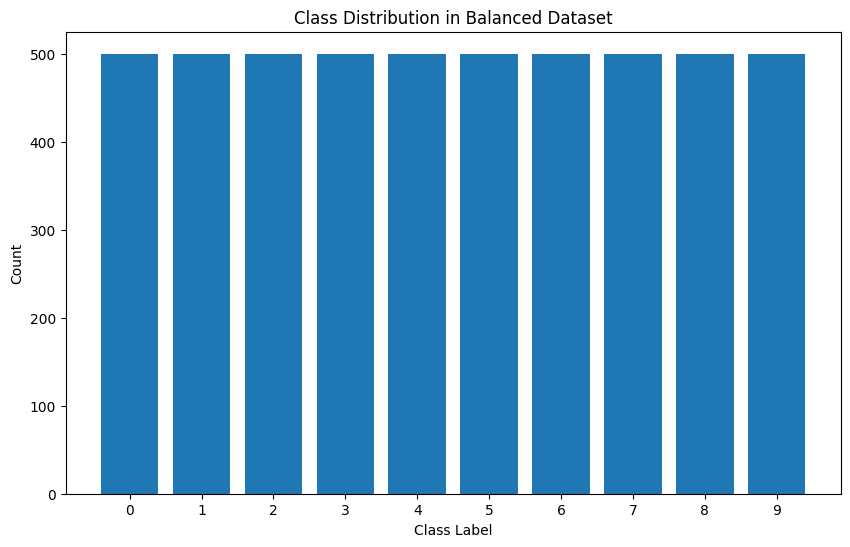

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a list 'balanced_labels' containing the labels of your balanced dataset
# For example, you can use the 'balanced_labels' from the previously provided code to create a balanced dataset

# Calculate the class distribution in the balanced dataset
unique_labels, class_counts = np.unique(balanced_labels, return_counts=True)

# Create a bar diagram to visualize the class distribution
plt.figure(figsize=(10, 6))
plt.bar(unique_labels, class_counts)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Class Distribution in Balanced Dataset')
plt.xticks(unique_labels)  # Set x-axis ticks to class labels
plt.show()


In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Initialize lists to store accuracies for each classifier
svm_accuracies = []
rf_accuracies = []
knn_accuracies = []

for p in range(20):
    mjcn_model = create_mjcn_model(input_shape, num_filters_conv, num_filters_mult, L1, L2)
    print(f"Population {p}")

    max_iter = 200
    mjcn_model = optimize_model(mjcn_model, balanced_images, balanced_labels_one_hot, max_iter, r1=0.5, r2=0.5)

    train_features = get_features(mjcn_model, balanced_images)

    # Classify with SVM
    svm_classifier = SVC()
    svm_classifier.fit(train_features, balanced_labels)
    svm_predicted_labels = svm_classifier.predict(train_features)
    svm_accuracy = accuracy_score(balanced_labels, svm_predicted_labels)
    svm_accuracies.append(svm_accuracy)

    # Classify with Random Forest
    rf_classifier = RandomForestClassifier()
    rf_classifier.fit(train_features, balanced_labels)
    rf_predicted_labels = rf_classifier.predict(train_features)
    rf_accuracy = accuracy_score(balanced_labels, rf_predicted_labels)
    rf_accuracies.append(rf_accuracy)

    # Classify with KNN
    knn_classifier = KNeighborsClassifier(n_neighbors=5)
    knn_classifier.fit(train_features, balanced_labels)
    knn_predicted_labels = knn_classifier.predict(train_features)
    knn_accuracy = accuracy_score(balanced_labels, knn_predicted_labels)
    knn_accuracies.append(knn_accuracy)

    print(f"Accuracy (SVM): {svm_accuracy:.2f}")
    print(f"Accuracy (Random Forest): {rf_accuracy:.2f}")
    print(f"Accuracy (KNN): {knn_accuracy:.2f}")




Streaming output truncated to the last 5000 lines.
current--------- inter_class_distance tf.Tensor(0.0, shape=(), dtype=float32) intra_class_variance tf.Tensor(0.88997793, shape=(), dtype=float32)
updated--------- inter_class_distance tf.Tensor(0.0, shape=(), dtype=float32) intra_class_variance tf.Tensor(0.8983307, shape=(), dtype=float32)
epoch 42--------
157/157 [==============================] - 2s 10ms/step
current--------- inter_class_distance tf.Tensor(0.0, shape=(), dtype=float32) intra_class_variance tf.Tensor(0.88997793, shape=(), dtype=float32)
updated--------- inter_class_distance tf.Tensor(0.0, shape=(), dtype=float32) intra_class_variance tf.Tensor(0.90387625, shape=(), dtype=float32)
epoch 43--------
157/157 [==============================] - 2s 10ms/step
current--------- inter_class_distance tf.Tensor(0.0, shape=(), dtype=float32) intra_class_variance tf.Tensor(0.88997793, shape=(), dtype=float32)
updated--------- inter_class_distance tf.Tensor(0.0, shape=(), dtype=float

In [ ]:
train_features = get_features(mjcn_model, balanced_images)

# Classify with SVM
svm_classifier = SVC()
svm_classifier.fit(train_features, balanced_labels)
svm_predicted_labels = svm_classifier.predict(train_features)
svm_accuracy = accuracy_score(balanced_labels, svm_predicted_labels)


# Classify with Random Forest
rf_classifier = RandomForestClassifier()
rf_classifier.fit(train_features, balanced_labels)
rf_predicted_labels = rf_classifier.predict(train_features)
rf_accuracy = accuracy_score(balanced_labels, rf_predicted_labels)


# Classify with KNN
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_features, balanced_labels)
knn_predicted_labels = knn_classifier.predict(train_features)
knn_accuracy = accuracy_score(balanced_labels, knn_predicted_labels)


print(f"Accuracy (SVM): {svm_accuracy:.2f}")
print(f"Accuracy (Random Forest): {rf_accuracy:.2f}")
print(f"Accuracy (KNN): {knn_accuracy:.2f}")